# **In this notebook, we will be looking at different models to help us predict stock prices based on the Sentiments of News Articles.**


---



# Import required packages

In [1]:
pip install vaderSentiment

In [2]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import sklearn.model_selection as ms
import sklearn.discriminant_analysis as sk
import re
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Data

We will be working with the following datasets:
1. Combined_News_DJIA.csv: Kaggle Datasets that contain Top 25 news headlines from 2008 to 2016, as well as labels for DJIA
2. 100_to_25_reddit.csv: Scrapped the Web for Top 100 News articles from 2008 to 2020. This will ensure that we have at least the Top 25 News article headlines a day.
3. SPY stock data from 2008 to 2020

In [1]:
from google.colab import files
files.upload()

# Data Exploration

In [3]:
df1_djinews = pd.read_csv('Combined_News_DJIA (3).csv')
#df2 = pd.read_csv('upload_DJIA_table.csv')
df2_spynews = pd.read_csv('100_to_25_reddit (3).csv')
df3_spyprice = pd.read_csv('SPY20080808-20201021 (3).csv')

In [4]:
df2_spynews.head()

,dates,title
0,2010-01-01,Is aviation security mostly for show?
1,2010-01-01,Did Harvard managers engage in corrupt deals?
2,2010-01-01,Fools and their Money - Investment Advisors
3,2010-01-01,How To Choose A Reliable Web Hosting Company
4,2010-01-01,Three Essential Things To Build Your Email List


From our new data that we scrapped from Reddit, we will take the Top 25 News Articles a day, after 2016-07-01 and append to the Kaggle DataSet that already has the info from 2008-08-08 to 2016-07-01.

In [5]:
pd.set_option('display.max_rows', 10)
df2_spynews = df2_spynews.loc[df2_spynews['dates'] > '2016-07-01']
print(df2_spynews)

            dates                                              title
59236  2016-07-02  Macy's banned from detaining and fining allege...
59237  2016-07-02  The WRT54GL: A 54Mbps router from 2005 still m...
59238  2016-07-02  Google, Facebook, Salesforce and one other unn...
59239  2016-07-02  Chipotle acts quickly after exec indicted on d...
59240  2016-07-02                 Question about quoted share prices
...           ...                                                ...
98556  2020-10-21  How Online Flowers Delivery Dubai Makes Events...
98557  2020-10-21  Medical Smart Textile 2020 Global Market Size,...
98558  2020-10-21  Global Corporate Learning Management System(LM...
98559  2020-10-21  Global Airlines Market 2020 Emerging Trends, S...
98560  2020-10-21  Global Industrial Robotics Market 2020 Emergin...

[39325 rows x 2 columns]


Transform the DataFrame to contain columns with Top 1 - Top 25 News Articles, we will call this temporary dataframe df4.

In [6]:
Dates = df2_spynews['dates'].unique().tolist()
Columns = []
Columns.append('Date')
for x in range(1,26):
    Columns.append('Top{}'.format(x))
df4 = pd.DataFrame(columns = Columns)
for date in Dates:
    new_row = []
    new_row.append(date)
    top25 = df2_spynews.loc[df2_spynews['dates'] == date,'title'].tolist()
    for headline in top25:
        new_row.append(headline)
    if (len(new_row) == 26):
        df4_length = len(df4)
        df4.loc[df4_length] = new_row

Drop the current Label Column from the Kaggle DataSet as we will calculate and append a new label column corresponding to S&P stock later.

In [2]:
df1_djinews.drop(['Label'],axis=1,inplace=True)
df1_djinews.head()

In [8]:
df1_djinews['Date'] = pd.to_datetime(df1_djinews['Date'], dayfirst=True)

**Remove the HTML tags**
There are several non-word tags in the headlines that would just bias the sentiment analysis so we need to remove them and replace with ". This can be done with regex.

In [3]:
df1_djinews = df1_djinews.replace('b\"|b\'|\\\\|\\\"', '', regex=True)
df1_djinews.tail(2)

In [4]:
df4['Date'] = pd.to_datetime(df4['Date'], yearfirst=True)
df4 = df4.replace('b\"|b\'|\\\\|\\\"', '', regex=True)
df4.head(2)

Great! Now we will merge the kaggle Top 25 news dataset with our additional Top 25 news dataset, to get a complete dataset with Top 25 news daily, from the 2008 to 2020. We shall call this dataset "combined_news".

In [5]:
#frames = [df1_djinews, df4]
#combined_news = pd.concat(frames)
#combined_news.head(5)

In the combined_news dataset, we have 3562 rows as this dataset still contains certain "WeekEnd" days, where the stock market is close. 

We will remove these days later, when we merge this dataset with the SPY dataset.

In [13]:
combined_news.shape

(3562, 26)

Now we shall calculate our Labels, that will indicate if the price of the stock rose or stayed the same the next day, indicated by "1", and if the price of the stock fell the next day, indicated by "0".

We will calculate our labels based on the daily Adjusted Close ONLY, as the close price is a strong indicator that traders look at, when deciding whether to buy or sell a stock.

In [14]:
df3_spyprice['label'] = np.where(df3_spyprice['Close'].diff() >= 0, 1, 0)
df3_spyprice['label'] = df3_spyprice['label'].shift(-1)
df3_spyprice = df3_spyprice[:-1]
df3_spyprice['label'] = df3_spyprice['label'].astype(int)
df3_spyprice

,Date,Open,High,Low,Close,Adj Close,Volume,label
0,2008-08-08,126.580002,129.929993,126.379997,129.369995,100.655472,260811700,1
1,2008-08-11,129.470001,131.509995,129.229996,130.710007,101.698029,249425800,0
2,2008-08-12,130.279999,130.699997,128.729996,129.350006,100.639908,213200800,0
3,2008-08-13,128.789993,129.649994,127.669998,128.570007,100.033035,256393200,1
4,2008-08-14,127.839996,130.279999,127.750000,129.539993,100.787720,239555300,1
...,...,...,...,...,...,...,...,...
3067,2020-10-14,350.750000,351.929993,347.140015,347.929993,347.929993,57958700,0
3068,2020-10-15,343.709991,348.019989,343.130005,347.500000,347.500000,60357700,0
3069,2020-10-16,348.959991,350.750000,347.100006,347.290009,347.290009,89501900,0
3070,2020-10-19,348.649994,349.329987,341.040009,342.010010,342.010010,68425600,1


Now that we have our labels calculated, we can safely drop the other columns so that we can avoid data contamination when we train our model later. We will only need to keep the date, close and labels for now.

In [15]:
df3_spyprice = df3_spyprice.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], axis=1)

Standardising the data type of the Date column

In [16]:
df3_spyprice['Date'] = pd.to_datetime(df3_spyprice['Date'], yearfirst=True)


In [18]:
df3_spyprice.head(2)

,Date,Close,label
0,2008-08-08,129.369995,1
1,2008-08-11,130.710007,0


In [19]:
df3_spyprice.shape

(3072, 3)

In [20]:
df3_spyprice.dtypes

Date     datetime64[ns]
Close           float64
label             int64
dtype: object

Now that we got our labels, lets merge the Top 25 daily news headlines together with thier labels, by doing an inner join on the "Date".

In [21]:
news_label_merge = combined_news.merge(df3_spyprice, how='inner', on='Date')
clean_dataset = news_label_merge
clean_dataset.shape


(3072, 28)

**NA Treatment**

We check if there is any NA values in our dataset. 


In [22]:
#Check for NaN's
print(clean_dataset.isnull().sum())

Date     0
Top1     0
Top2     0
Top3     0
Top4     0
        ..
Top23    0
Top24    0
Top25    0
Close    0
label    0
Length: 28, dtype: int64


In [23]:
is_NaN = clean_dataset.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = clean_dataset[row_has_NaN]
print(rows_with_NaN)

Empty DataFrame
Columns: [Date, Top1, Top2, Top3, Top4, Top5, Top6, Top7, Top8, Top9, Top10, Top11, Top12, Top13, Top14, Top15, Top16, Top17, Top18, Top19, Top20, Top21, Top22, Top23, Top24, Top25, Close, label]
Index: []


In [7]:
clean_dataset.head(10)

Awesome! We now have 3072 rows, and have remove all days with news where the stock market is closed! We are now ready to use this clean_dataset for the next step of Feature Extraction, and Model Testing!

# Data Cleaning & Feature Extraction

We will now combine the news headlines from the 25 days into one long string, for Sentiment Analysis, and create a new column called "Combined_News". We will also parse the combine string of 25 news headlines, to convert the string to all lower case letters. We do not need to remove punctuations as vader is able to use these information to better extract the sentiments. 

In [25]:
#Combine the top news headlines
headlines = []
for row in range(0,len(clean_dataset.index)):
    headlines.append(' '.join(str(x) for x in clean_dataset.iloc[row,1:26]))
#Clean the data
clean_headlines = []
for i in range(len(headlines)):
  clean_headlines.append(headlines[i].lower())
clean_dataset['Combined_News'] = clean_headlines

In [8]:
clean_dataset.head(3)

In [27]:
clean_dataset.shape

(3072, 29)

# Feature Engineering & Sentiment Analysis
TextBlob gives us the subjectivity and polarity of the text. Using Vader Sentiment we are also able to obtain the sentiment scores for each day. 


Subjectivity refers to how opinionated the text is. [0,1]

Polarity refers to how positive or negative the text is. [-1,1]


Positive and Negative would show the positive and negative sentiments of the text respectively. [0,1]

Compound is the a normalized score computed  based on some heuristics and a sentiment intensity. [-1, 1]



In [28]:
# Create a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity
# Create a function to get the polarity
def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [29]:
#Create two new columns 'Subjectivity' & 'Polarity'
clean_dataset['Subjectivity'] = clean_dataset['Combined_News'].apply(getSubjectivity)
clean_dataset['Polarity'] = clean_dataset['Combined_News'].apply(getPolarity)

In [30]:
#Create a function to get the sentiment scores (using Sentiment Intensity Analyzer)
def getSIA(text):
  sia = SentimentIntensityAnalyzer()
  sentiment = sia.polarity_scores(text)
  return sentiment

In [31]:
#Get the sentiment scores for each day
compound = []
neg = []
neu = []
pos = []
SIA = 0
for i in range(0, len(clean_dataset['Combined_News'])):
  SIA = getSIA(clean_dataset['Combined_News'][i])
  compound.append(SIA['compound'])
  neg.append(SIA['neg'])
  neu.append(SIA['neu'])
  pos.append(SIA['pos'])

In [32]:
#Store the sentiment scores in the data frame
clean_dataset['Compound'] = compound
clean_dataset['Negative'] = neg
clean_dataset['Neutral'] = neu
clean_dataset['Positive'] = pos

In [9]:
Create a list of columns to keep [ 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive', 'Adj Close', 'Label']
keep_columns = ['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive', 'Close', 'label']
df = clean_dataset[keep_columns]
df

# Train-Test Split
We split the data set into 80% for training and 20% for testing. As this is a time series, it is important we do not randomly pick training and testing samples.

In [34]:
#Create the feature data set
X = df
X = X.drop(['label'],1)
#Create the target data set
y = df['label']

In [35]:
y

0       1
1       0
2       0
3       1
4       1
       ..
3067    0
3068    0
3069    0
3070    1
3071    0
Name: label, Length: 3072, dtype: int64

In [36]:
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Close
0,0.267549,-0.048568,-0.9982,0.235,0.724,0.041,129.369995
1,0.374806,0.121956,-0.9858,0.191,0.720,0.089,130.710007
2,0.518785,-0.046530,-0.9715,0.127,0.817,0.055,129.350006
3,0.364021,0.011398,-0.9809,0.146,0.788,0.066,128.570007
4,0.375099,0.040677,-0.9882,0.188,0.719,0.093,129.539993
...,...,...,...,...,...,...,...
3067,0.418750,0.232197,0.9836,0.016,0.810,0.175,347.929993
3068,0.345455,0.340909,0.9810,0.021,0.808,0.171,347.500000
3069,0.505102,0.411650,0.9863,0.038,0.758,0.204,347.290009
3070,0.554056,0.328447,0.9950,0.009,0.762,0.229,342.010010


In [37]:
#Split the data into 80% training and 20% testing data sets
train_size = int(len(X.index) * 0.8)
x_train, x_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
y_train, y_test = y.loc[0:train_size], y.loc[train_size: len(X.index)]

In [38]:
x_train

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Close
0,0.267549,-0.048568,-0.9982,0.235,0.724,0.041,129.369995
1,0.374806,0.121956,-0.9858,0.191,0.720,0.089,130.710007
2,0.518785,-0.046530,-0.9715,0.127,0.817,0.055,129.350006
3,0.364021,0.011398,-0.9809,0.146,0.788,0.066,128.570007
4,0.375099,0.040677,-0.9882,0.188,0.719,0.093,129.539993
...,...,...,...,...,...,...,...
2453,0.305556,0.224444,0.8225,0.047,0.877,0.076,266.920013
2454,0.335812,0.107962,0.9498,0.051,0.833,0.115,269.500000
2455,0.428435,0.094646,0.7059,0.093,0.799,0.108,272.019989
2456,0.382671,0.143966,0.9743,0.055,0.797,0.148,272.850006


# Models
We defined a few models to test our data on and we observed that LDA performs the best so far.

In [39]:
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))


LR: 0.567479674796748
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       266
           1       0.57      1.00      0.72       349

    accuracy                           0.57       615
   macro avg       0.28      0.50      0.36       615
weighted avg       0.32      0.57      0.41       615

[[  0 266]
 [  0 349]]
LDA: 0.567479674796748
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       266
           1       0.57      0.99      0.72       349

    accuracy                           0.57       615
   macro avg       0.53      0.50      0.37       615
weighted avg       0.54      0.57      0.42       615

[[  3 263]
 [  3 346]]
KNN: 0.47804878048780486
              precision    recall  f1-score   support

           0       0.44      0.79      0.57       266
           1       0.60      0.24      0.34       349

    accuracy                           0.48       615
   macro avg

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM: 0.567479674796748
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       266
           1       0.57      1.00      0.72       349

    accuracy                           0.57       615
   macro avg       0.28      0.50      0.36       615
weighted avg       0.32      0.57      0.41       615

[[  0 266]
 [  0 349]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF: 0.4878048780487805
              precision    recall  f1-score   support

           0       0.44      0.65      0.52       266
           1       0.58      0.36      0.45       349

    accuracy                           0.49       615
   macro avg       0.51      0.51      0.48       615
weighted avg       0.52      0.49      0.48       615

[[173  93]
 [222 127]]
XGBoost: 0.4926829268292683
              precision    recall  f1-score   support

           0       0.43      0.53      0.48       266
           1       0.56      0.46      0.51       349

    accuracy                           0.49       615
   macro avg       0.50      0.50      0.49       615
weighted avg       0.51      0.49      0.49       615

[[142 124]
 [188 161]]


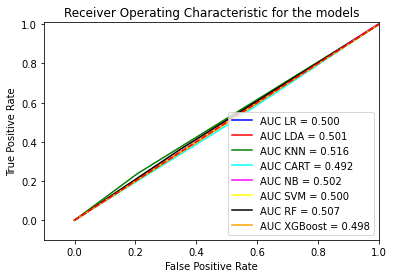

In [40]:
temp = ('blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange')
i=0
for name, model in models:
    clf = model
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    accu_score = accuracy_score(y_test, predictions)
    print(name + ": " + str(accu_score))
    print( classification_report(y_test, predictions) )
    print(confusion_matrix(y_test, predictions))

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, 'b',label='AUC %s = %0.3f'% (name,roc_auc),color = temp[i])
    i+=1


# Plot ROC
plt.title('Receiver Operating Characteristic for the models')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Scaling Data to train LDA

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
rescaledX = scaler.transform(x_train)
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(x_test)
predictions = model_lda.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

accuracy score:
0.567479674796748
classification report: 
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       266
           1       0.57      0.99      0.72       349

    accuracy                           0.57       615
   macro avg       0.53      0.50      0.37       615
weighted avg       0.54      0.57      0.42       615



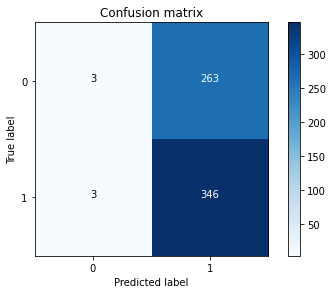

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

plt.figure()
lrConfM = confusion_matrix(y_test,predictions)
plot_confusion_matrix(lrConfM
                      , classes=[0,1]
                      , title='Confusion matrix')
plt.show()

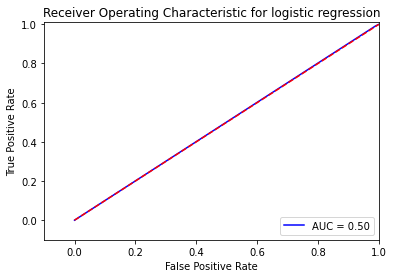

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic for logistic regression')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Using PCA to reduce dimensionality for XGboost (Removed as we are not dealing with high dimensionality data)

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7)
pca.fit(X)
transformed = pca.transform(X)

transformed.shape
print(type(transformed))
pca_df = pd.DataFrame(transformed)

X_train_pca, X_test_pca = pca_df.loc[0:train_size, :], pca_df.loc[train_size: len(X.index), :]

<class 'numpy.ndarray'>


In [46]:
clf = XGBClassifier()
clf.fit(X_train_pca, y_train)
y_pred_pca_untune = clf.predict(X_test_pca)
score = accuracy_score(y_test, y_pred_pca_untune)
print("Score is "+ str(score))

Score is 0.5170731707317073


# Tuning XGBoost 

We will now try different permutations of the Max_Depth and N_Estimators for our XGBoost Model, and see which one gives us the best result.

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='roc_auc',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [48]:
model = XGBClassifier()
param_grid = {
    'n_estimators': [150, 200, 250, 300, 350,400, 450, 500],
    'max_depth': [10, 11, 12,13,14,15,20,25],
}

model, pred = algorithm_pipeline(x_train, x_test, y_train, y_test, model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  6.7min finished


nan
{'max_depth': 10, 'n_estimators': 150}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


In [49]:
clf = XGBClassifier(n_estimators=150, max_depth=10)
clf.fit(x_train, y_train)
y_pred_pca_tune = clf.predict(x_test)
score = accuracy_score(y_test, y_pred_pca_tune)
print("Score is "+ str(score))

Score is 0.47804878048780486


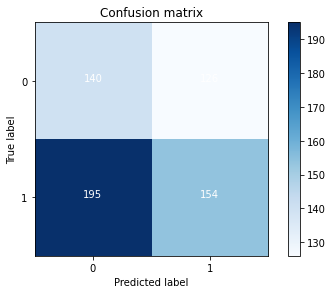

In [50]:
plt.figure()
lrConfM = confusion_matrix(y_test,y_pred_pca_tune)
plot_confusion_matrix(lrConfM
                      , classes=[0,1]
                      , title='Confusion matrix')
plt.show()

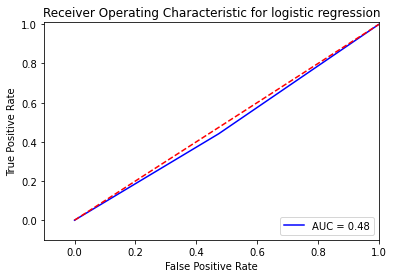

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_pca_tune)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic for logistic regression')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



---



# Other Exploration

*   Visualisation of Data
*   Model Experimentation 



We will now make a copy of our Clean_Dataset, as well as final dataset "df" to experiment with other models and visualisation.

In [52]:
df_test_cleaned = clean_dataset
df_test_cleaned.shape

(3072, 35)

In [53]:
df_test = df
df_test.head(2)

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Close,label
0,0.267549,-0.048568,-0.9982,0.235,0.724,0.041,129.369995,1
1,0.374806,0.121956,-0.9858,0.191,0.720,0.089,130.710007,0


In [54]:
df3_spyprice_test = pd.read_csv('SPY20080808-20201021.csv')
df3_spyprice_test.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
3068,2020-10-15,343.709991,348.019989,343.130005,347.500000,347.500000,60357700
3069,2020-10-16,348.959991,350.750000,347.100006,347.290009,347.290009,89501900
3070,2020-10-19,348.649994,349.329987,341.040009,342.010010,342.010010,68425600
3071,2020-10-20,343.459991,346.880005,342.640015,343.380005,343.380005,60051900
3072,2020-10-21,343.329987,348.679993,342.399994,342.730011,342.730011,63040400


In [55]:
df1_djinews_test = pd.read_csv('Combined_News_DJIA.csv')
df1_djinews_test.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


In [56]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split

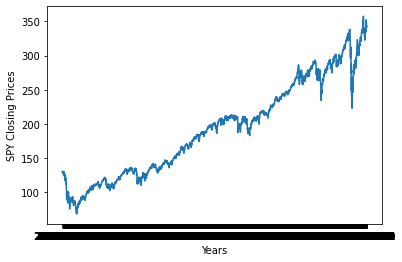

In [57]:
plt.plot(df3_spyprice_test['Date'], df3_spyprice_test['Close'])
plt.xlabel('Years')
plt.ylabel('SPY Closing Prices')
plt.show()

# Simple EDA 

We first have a quick look at the text, looking for words that can be the indicator of decrease on stock price.

In [58]:
train,test = train_test_split(df_test_cleaned,test_size=0.2,random_state=42)

The way the data and labels are structured can be a little confusing. We hope the explanation here will help to make things a little clearer. 

If the news for a current day X results in the rise of stocks the next day, the next day will have a label of "1" to indicate that the price rose or stayed the same. 

This means that the news for a current day does not indicate anything about the label for the day itself.

In [59]:
non_decrease = train[train['label']==1]
decrease = train[train['label']==0]
print(len(non_decrease)/len(df))

0.4430338541666667


We can see that the occurrence of non-decrease situation is almost the same as that of a decrease market.

In [60]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [61]:
def to_words(content):
    letters_only = re.sub("[^a-zA-Z]", " ", content) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [62]:
non_decrease_word=[]
decrease_word=[]
for each in non_decrease['Combined_News']:
    non_decrease_word.append(to_words(each))

for each in decrease['Combined_News']:
    decrease_word.append(to_words(each))

### Lets Visualise some of the most common words that result in a decrease in stock prices the next day

In [63]:
wordcloud1 = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(decrease_word[0])

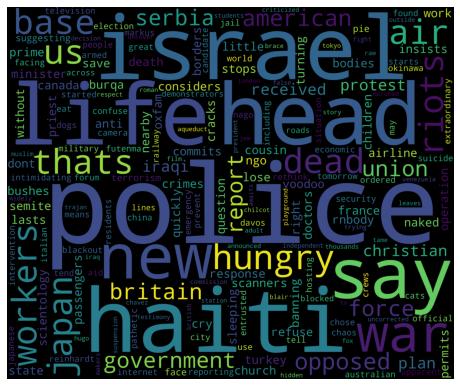

In [64]:
plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

### And here are the most common words that result in a rise or no change in the stock price the next day

In [65]:
wordcloud2 = WordCloud(background_color='white',
                      width=3000,
                      height=2500
                     ).generate(non_decrease_word[0])

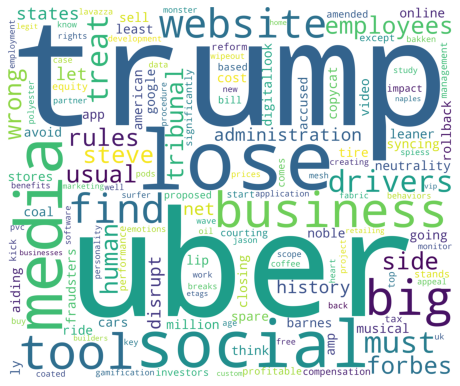

In [66]:
plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

By looking at the two word clouds, we found that even in the case of words that led to a non-decreasing next day stock price situation, the Political sensitive words are dominant. Therefore, the overall results of the classification may not be quite good since the features of two classes are not that distinct.

# Plot a histogram for all the columns of the dataframe. This shows the frequency of values in all the columns.

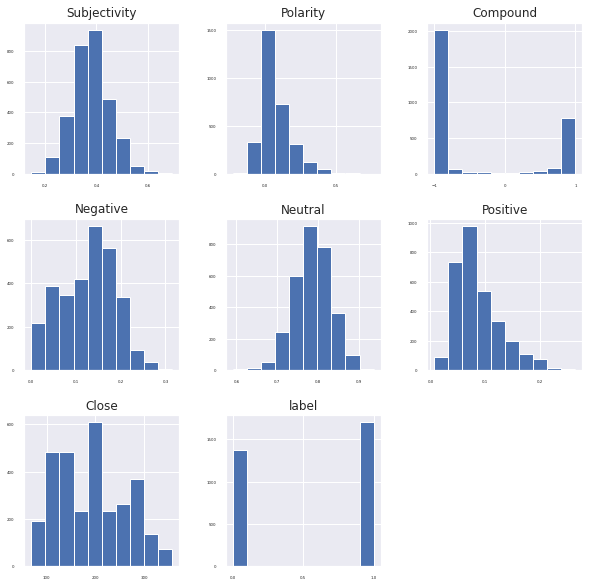

In [67]:
import seaborn as sns
from matplotlib import pyplot
df_test = df 
sns.set()
df_test.hist(sharex = False, sharey = False, xlabelsize = 4, ylabelsize = 4, figsize=(10, 10))
pyplot.show()

### Correlation Map for features:

Now, we will plot a heat map and a scatter matrix to see the correlation of the columns with each other.

You can see the heat map with pearson correlation values in the plot below.

This gave us a better understanding to see if there are any dependant variables or if any of the variables are highly correlated.

Some variables Compound, Negative are negatively correlated. There are very few variables which seem to have a very high correlation. Thus, at this point we can conclude that we do not need any sort of dimensionality reduction technique to be applied.

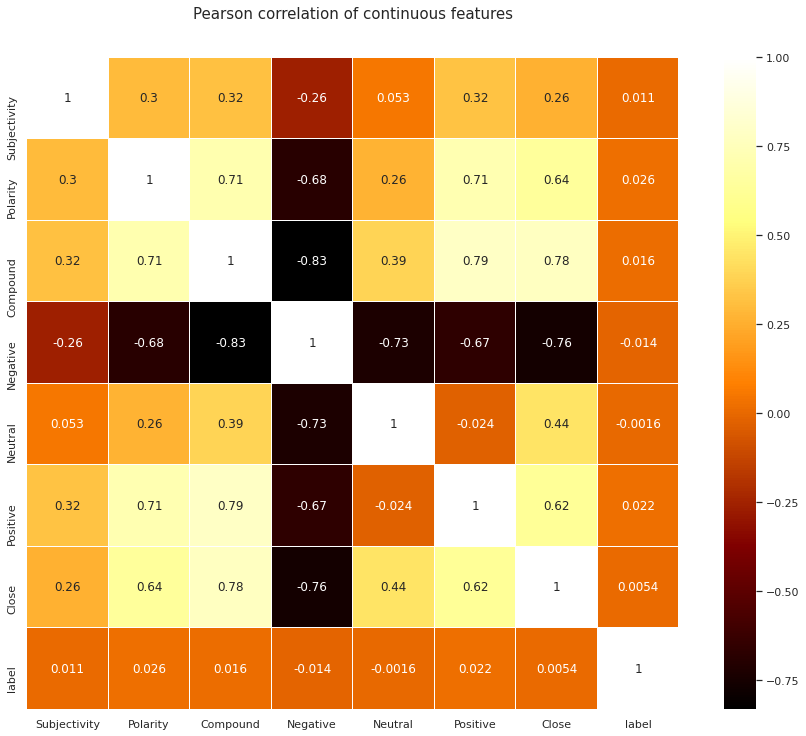

In [68]:
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(df_test.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()